# Primer examen parcial (parte práctica)

Instrucciones:
* Haga una copia de este notebook a su drive (File -> Save a copy in drive)
* Cree una celda inicial, con las funciones que requiera.
* Para cada punto, ejecute los algoritmos , muestre los resultados y escriba la respuesta.

# Funciones

In [125]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [126]:
def normalize(lis, max):
    return np.array([i/max for i in lis])

## Chi Cuadrado

In [127]:
def getOF( dataArr, c , maxVal):
    dataArr = np.sort(dataArr)
    delta = maxVal / c
    of = np.zeros( c , dtype=int)

    index = 0
    for i in range( c ):
        while dataArr[index] <= (i+1)*delta:
            of[i] += 1
            index += 1
            if index >= dataArr.size:
                break
    return of

In [128]:
def getEF( c , n):
    ef = np.array( [n/c] * c )
    return ef

In [129]:
def chi2Test(data, alpha):
    maxVal = np.max(data)
    c = math.ceil( math.sqrt(data.size) )
    observedFreq = getOF( data, c , maxVal)
    expectedFreq = getEF( c , data.size)
    chi2Calc = np.sum( (observedFreq - expectedFreq)**2 / expectedFreq )
    criticVal = stats.chi2.ppf(q = 1-alpha, df = c-1)
    print("Chi2 Calculado: ", chi2Calc)
    print("Chi2 Critico: ", criticVal)
    if (chi2Calc > criticVal):
        print("Se rechaza la hipótesis nula")
        return False
    else:
        print("No se rechaza la hipótesis nula")
        return True


## Series

In [130]:
# Asumiendo que num pertenece al rango [start, end], y que dicho rango
# está dividido en L intervalos, devuelve el número de intervalo.
# Los intervalos se enumeran desde 0 hasta L-1.
# siendo el intervalo [0.1,0.2) el intervalo 1, para start = 0, end = 1, L = 10.
# El último intervalo es cerrado en ambos extremos, y los demás son cerrados
# en el extremo inferior y abiertos en el extremo superior.
def getInterval(start, end, L, num):
    if (num > end):
        print("Error: número fuera de rango")
        return

    intervalSize = (end - start) / L
    interval = math.floor((num - start) / intervalSize)
    if (interval == L):
        interval = L - 1
    #print(f"num: {num}")
    #print(f"IntervalSize: {intervalSize}")
    #print(f"Interval: {interval}")
    return interval

In [131]:
# k := Cantidad de dimensiones
def obsFreqMatrixSeries(datos, start, maxVal, k):
    #print(f"datos : {datos}")
    datos = normalize(datos.copy(), maxVal)
    #print(f"datos normalizados: {datos}")
    n = len(datos)
    g = int(n / k)       # Cantidad de grupos (tuplas)
    #c = ceil(sqrt(g))   # Cantidad de clases
    intervs = math.ceil( pow( g, 1/(2*k) ) )  # Cantidad de intervalos para cada dimensión
    print(f"intervs: {intervs}")
    obsFreqs = np.zeros((intervs ** (k - 1),intervs), dtype=int)   
    
    for i in range (g):
        #col = getIntervalSeries(intervs, datos[i * k + (k - 1)])
        col = getInterval(start, maxVal, intervs, datos[i * k + (k - 1)])
        row = 0
        for dim in range (k - 1):
            row += getInterval(start, maxVal, intervs, datos[i * k + dim]) * (intervs ** (k - dim - 2))
        obsFreqs[row][col] += 1
    return obsFreqs

In [160]:
# k := Cantidad de dimensiones
def testSeries(datos, maxVal, k, significanceLevel):
    datos = normalize(datos.copy(), np.max(datos))
    maxVal = 1

    
    conf = 1 - significanceLevel
    n = len(datos)
    g = int(n / k)       # Cantidad de grupos (tuplas)
    intervs = math.ceil( pow( g, 1/(2*k) ) )  # Cantidad de intervalos para cada dimensión
    print(f"intervs = {intervs}")
    obsMatrix = obsFreqMatrixSeries(datos, 0, maxVal, k)
    print("Matriz de frecuencias observadas:")
    print(obsMatrix)

    # Expected frequency:
    ef = g / (intervs ** k)
    print(f"ef = {ef}")
    
    finalMatrix = ((ef - obsMatrix)**2) / ef
    print(f"finalMatrix: {finalMatrix}")

    # Valor calculado para la prueba de Chi cuadrado
    calculated = np.sum(finalMatrix)

    freedomDegrees = (intervs ** k) - 1

    # Prueba de Chi2 directa entre obsMatrix y una matriz con los valores esperados.
    chi2Result = stats.chisquare( obsMatrix.reshape(intervs**k), np.full((intervs ** k), ef) )
    #print( f"Chi2 directa: {chi2Result}" )
    #print ((1-chi2Result[1]) < conf)

    # 
    # Valor crítico
    criticVal = stats.chi2.ppf(conf, freedomDegrees)

    # resultado manual
    print("Valor calculado: ", calculated) 
    print("Valor crítico: ", criticVal)
    return calculated <= criticVal

## Kolmogorov-smirnov

In [133]:
# n := Cantidad de números aleatorios
# c := Cantidad de intervalos

def uniformePEA(n):
    c = math.ceil(math.sqrt(n))
    lis = np.array([1/c * (i + 1) for i in range(c)])
    return lis

In [134]:
def countFreqs(data, maxVal, c):
    n = len(data)
    freqList = np.zeros(c, dtype = int)
    for i in range(n):
        if (data[i] == maxVal):
            freqList[c - 1] += 1
        else:
            freqList[math.floor( (data[i] * c / maxVal) )] += 1
    return freqList

In [135]:
def classifyKS(data, maxVal):
    n = len(data)
    c = math.ceil(math.sqrt(n))
    freqList = countFreqs(data, maxVal, c)
    return freqList

In [136]:
# Calcula el DMcalc del test de Kolmogorov-Smirnov
def dmCalc_kolmogorov_Smirnov(n, lisFO):
    c = len(lisFO)
    gl = n  # Grados de libertad

    lisPEA = uniformePEA(n)

    lisFOA = np.cumsum(lisFO)

    lisPOA = list ( map ( lambda x: x / n , lisFOA ))

    v1 = lisPEA[0]
    v2 = lisPOA[0]

    difs = np.abs(lisPEA - lisPOA)
    d = round(difs.max(), 2)

    return d

In [137]:
# for a 0.01, 0.05 or 0.10 significance level
def critValKolmogorov(n, significanceLevel):
    if (significanceLevel == 0.01):
        if (n > 20):
            return 1.63 / math.sqrt(n)

        elif (n == 5):
            return 0.669
        elif (n == 8):
            return 0.543
        elif (n == 10):
            return 0.490
        elif (n == 12):
            return 0.450
        elif (n == 15):
            return 0.404
        elif (n == 20):
            return 0.356
    elif (significanceLevel == 0.05):
        if (n > 20):
            return 1.36 / math.sqrt(n)

        elif (n == 5):
            return 0.565
        elif (n == 8):
            return 0.457
        elif (n == 10):
            return 0.410
        elif (n == 12):
            return 0.375
        elif (n == 15):
            return 0.338
        elif (n == 20):
            return 0.294
    elif (significanceLevel == 0.10):
        if (n > 20):
            return 1.22 / math.sqrt(n)

        elif (n == 5):
            return 0.510
        elif (n == 8):
            return 0.411
        elif (n == 10):
            return 0.368
        elif (n == 12):
            return 0.338
        elif (n == 15):
            return 0.304
        elif (n == 20):
            return 0.264

In [138]:
# Funciona para los valores de n: {5, 8, 10, 12, 15, 20}, para n > 20 
# y para una significancia de 0.01, 0.05 o 0.10 
def kolmogorovTest(data, maxVal, significanceLevel):
    n = len(data)
    lisFo = classifyKS(data, maxVal)
    dmCalc = dmCalc_kolmogorov_Smirnov(n, lisFo)
    critVal = critValKolmogorov(n, significanceLevel)
    print(f"dmCalc = {dmCalc}")
    print(f"critVal = {critVal}")
    if (dmCalc > critVal):
        #print("Se rechaza la hipotesis nula")
        return False
    else:
        #print("No se rechaza la hipotesis nula")
        return True

## Transformada Inversa

In [139]:
def getCumulativeProbDist(data):
    sortedData = data.copy()
    sortedData.sort()
    uniques, counts = np.unique(sortedData, return_counts=True)
    cumProbability = np.array([uniques, counts.cumsum() / data.size]).T
    return cumProbability

In [140]:
def getCumProb(num, cumProbabilityDist):
    for i in range (cumProbabilityDist.shape[0]):
        #print(cumProbabilityDist[i][0], cumProbabilityDist[i][1])
        if num == cumProbabilityDist[i,0]:
            return cumProbabilityDist[i,1]
    print("Error: number not found in distribution")
    return

In [141]:
def inverTransform(cumProb, discreteCumDist):
    if (cumProb < 0 or cumProb > 1):
        print("Probability must be between 0 and 1")
        return
    elif (cumProb == 1):
        return discreteCumDist[len(discreteCumDist)-1,0]
    else:
        for i in range (discreteCumDist[:,1].size):
            #print(discreteCumDist[i,1])
            if cumProb <= discreteCumDist[i,1]:
                return discreteCumDist[i,0]

## Generación secuencia exponencial

In [142]:
def transformToExponencial(data, lamb):
    return list(map(lambda x: -math.log(x)/lamb, data))

# Examen

Considere los siguientes datos que se encuentran en una
distribución uniforme discreta entre 0 y 8


5 8 4 7 8 2 4 4 3 5 6 7 8 4 8 7 3 4 5 6
3 5 6 1 2 3 2 5 6 7 8 7 1 5 6 7 3 4 2 0
3 2 0 0 1 0 2 1 3 4 4 6 7 1 0 8 8 3 1 0
1 4 7 2 1 4 7 5 6 7 2 4 8 6 7 5 8 2 1 6
4 5 1 2 4 0 2 7 1 6 7 0 8 1 5 4 6 1 4 3



In [143]:
data = np.array([5, 8, 4, 7, 8, 2, 4, 4, 3, 5, 6, 7, 8, 4, 8, 7, 3, 4, 5, 6,
3, 5, 6, 1, 2, 3, 2, 5, 6, 7, 8, 7, 1, 5, 6, 7, 3, 4, 2, 0,
3, 2, 0, 0, 1, 0, 2, 1, 3, 4, 4, 6, 7, 1, 0, 8, 8, 3, 1, 0,
1, 4, 7, 2, 1, 4, 7, 5, 6, 7, 2, 4, 8, 6, 7, 5, 8, 2, 1, 6,
4, 5, 1, 2, 4, 0, 2, 7, 1, 6, 7, 0, 8, 1, 5, 4, 6, 1, 4, 3])
data.size

100

In [144]:
np.max(data)

8

1. Aplique una prueba de chi-cuadrado con $\alpha = 0.05$

In [145]:
alpha = 0.05
chi2Test(data, alpha)

Chi2 Calculado:  15.0
Chi2 Critico:  16.918977604620448
No se rechaza la hipótesis nula


True

Los datos pasan la prueba de chi-cuadrado

2. Aplique una prueba de series de dos dimensiones con $\alpha = 0.1$

In [165]:
np.max(data)

8

In [167]:
testSeries(data, np.max(data), 2, 0.1)

intervs = 3
intervs: 3
Matriz de frecuencias observadas:
[[6 6 4]
 [2 9 4]
 [8 4 7]]
ef = 5.555555555555555
finalMatrix: [[0.03555556 0.03555556 0.43555556]
 [2.27555556 2.13555556 0.43555556]
 [1.07555556 0.43555556 0.37555556]]
Valor calculado:  7.24
Valor crítico:  13.36156613651173


True

Los datos pasan el test de series

3. Aplique una prueba de Kolmogorov-Smirvov con confianza $\alpha = 0.05$

In [148]:
kolmogorovTest(data, np.max(data), 0.05) 
#Se prueba la funcion con una secuencia uniforme generada por la libreria numpy, dando como resultado que si pasa la prueba

dmCalc = 0.09
critVal = 0.136


True

Los datos pasan el test de Kolmogorov-Smirnov

4. Bajo el método de la transformación inversa, transforme el conjunto dado a la
siguiente distribución discreta:

| **vi** | **pi** |
| --- | --- |
| 0 | 0.1 |
| 2 | 0.3 |
| 3 | 0.05 |
| 4 | 0.1 |
| 7 | 0.15 |
| 9 | 0.1 |
| 10 | 0.05 | 
| 13 | 0.05 |
| 15 | 0.1 |



In [149]:
discreteDist = np.array([[0, 2, 3, 4, 7, 9, 10, 13, 15], 
                        [0.1, 0.3, 0.05, 0.1, 0.15, 0.1, 0.05, 0.05, 0.1]]).T
discreteDist

array([[ 0.  ,  0.1 ],
       [ 2.  ,  0.3 ],
       [ 3.  ,  0.05],
       [ 4.  ,  0.1 ],
       [ 7.  ,  0.15],
       [ 9.  ,  0.1 ],
       [10.  ,  0.05],
       [13.  ,  0.05],
       [15.  ,  0.1 ]])

In [150]:
cumProbability = getCumulativeProbDist(data)
cumProbability

array([[0.  , 0.08],
       [1.  , 0.21],
       [2.  , 0.32],
       [3.  , 0.41],
       [4.  , 0.56],
       [5.  , 0.66],
       [6.  , 0.77],
       [7.  , 0.9 ],
       [8.  , 1.  ]])

In [151]:
discreteCumulativeProb = np.array([discreteDist[:,0], discreteDist[:,1].cumsum()]).T
discreteCumulativeProb

array([[ 0.  ,  0.1 ],
       [ 2.  ,  0.4 ],
       [ 3.  ,  0.45],
       [ 4.  ,  0.55],
       [ 7.  ,  0.7 ],
       [ 9.  ,  0.8 ],
       [10.  ,  0.85],
       [13.  ,  0.9 ],
       [15.  ,  1.  ]])

In [152]:
cumProbsDataOriginalOrder = np.array(list(map(lambda x: getCumProb(x, cumProbability), data)))
cumProbsDataOriginalOrder.size

100

In [153]:
transformedData = np.array(list(map(lambda x: inverTransform(x, discreteCumulativeProb), 
                cumProbsDataOriginalOrder)), dtype=int)
transformedData

array([ 7, 15,  7, 13, 15,  2,  7,  7,  3,  7,  9, 13, 15,  7, 15, 13,  3,
        7,  7,  9,  3,  7,  9,  2,  2,  3,  2,  7,  9, 13, 15, 13,  2,  7,
        9, 13,  3,  7,  2,  0,  3,  2,  0,  0,  2,  0,  2,  2,  3,  7,  7,
        9, 13,  2,  0, 15, 15,  3,  2,  0,  2,  7, 13,  2,  2,  7, 13,  7,
        9, 13,  2,  7, 15,  9, 13,  7, 15,  2,  2,  9,  7,  7,  2,  2,  7,
        0,  2, 13,  2,  9, 13,  0, 15,  2,  7,  7,  9,  2,  7,  3])

5. Se desea usar los siguientes 30 números aleatorios para una simulación de una variable aleatoria exponencial con parámetro λ=3. Generar la secuencia de numeros bajo la distribución exponencial. (si puede mostrar la gráfica para verificar que es exponencial)


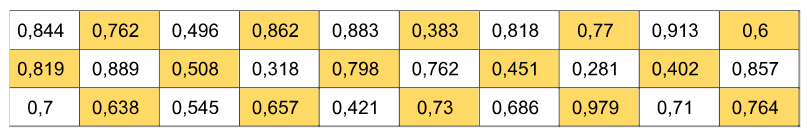
---



In [154]:
dataSimulacionExp = np.array(  [0.844, 0.762, 0.496, 0.862, 0.883, 0.383, 0.818, 0.77,  0.913, 0.6,
                                0.819, 0.889, 0.508, 0.318, 0.798, 0.762, 0.451, 0.281, 0.402, 0.857,
                                0.7,   0.638, 0.545, 0.657, 0.421, 0.73,  0.686, 0.979, 0.71,  0.764])
dataSimulacionExp

array([0.844, 0.762, 0.496, 0.862, 0.883, 0.383, 0.818, 0.77 , 0.913,
       0.6  , 0.819, 0.889, 0.508, 0.318, 0.798, 0.762, 0.451, 0.281,
       0.402, 0.857, 0.7  , 0.638, 0.545, 0.657, 0.421, 0.73 , 0.686,
       0.979, 0.71 , 0.764])

In [155]:
expData = transformToExponencial(dataSimulacionExp, 3)
expData

[0.05653426146206,
 0.0906029077651636,
 0.2337264507524032,
 0.049500002772814654,
 0.04147669279272568,
 0.31990676326716366,
 0.06696431412646335,
 0.08712158804480251,
 0.030339799462389516,
 0.1702752079219969,
 0.06655706504302257,
 0.03921934782274415,
 0.22575794380121839,
 0.3819012987339867,
 0.07521556051077607,
 0.0906029077651636,
 0.26542931315981955,
 0.42313353654946373,
 0.30376773012103864,
 0.0514391201281191,
 0.11889164797957748,
 0.14980566521244906,
 0.20232316143963094,
 0.1400237534991755,
 0.2883741484332519,
 0.10490358161323342,
 0.12562588375208392,
 0.007074545483875563,
 0.114163436315592,
 0.08972916327187218]

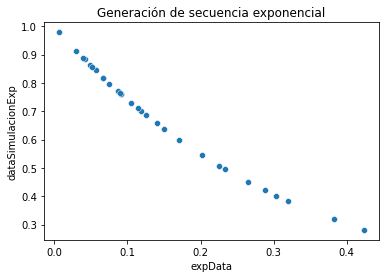

In [168]:
# scatter plot with axis labels
sns.scatterplot(x=expData, y=dataSimulacionExp)
plt.xlabel('expData')
plt.ylabel('dataSimulacionExp')
plt.title('Generación de secuencia exponencial')
plt.show()
